In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None
    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [3]:
# Reading Data
data_w = pd.read_excel('../raw_data/weekly_data_clean_with_covid.xlsx', engine='openpyxl')
data_d = pd.read_excel('../raw_data/daily_data_clean_with_covid.xlsx', engine='openpyxl')


In [4]:
# Dropping extra index column
data_w = data_w.drop(columns= 'Unnamed: 0')
data_d = data_d.drop(columns= 'Unnamed: 0')


In [5]:
#Check Nulls
data_w.isnull().sum(), data_d.isnull().sum()

(date_issue      0
 amount          0
 covid_claims    0
 dtype: int64,
 date_issue      0
 amount          0
 covid_claims    0
 dtype: int64)

In [6]:
# Check types and lenght
data_w.dtypes, len(data_w), data_d.dtypes, len(data_d)

(date_issue      datetime64[ns]
 amount                   int64
 covid_claims             int64
 dtype: object,
 132,
 date_issue      datetime64[ns]
 amount                   int64
 covid_claims             int64
 dtype: object,
 920)

In [7]:
# Setting index as date
data_w = data_w.set_index('date_issue')
data_d = data_d.set_index('date_issue')


In [8]:
data_d

,amount,covid_claims
date_issue,,
2018-09-01,168,0
2018-09-02,346,0
2018-09-03,16169,0
2018-09-04,28529,0
2018-09-05,64135,0
...,...,...
2021-03-04,350720,42
2021-03-05,293427,45
2021-03-06,333658,38


<AxesSubplot:xlabel='date_issue'>

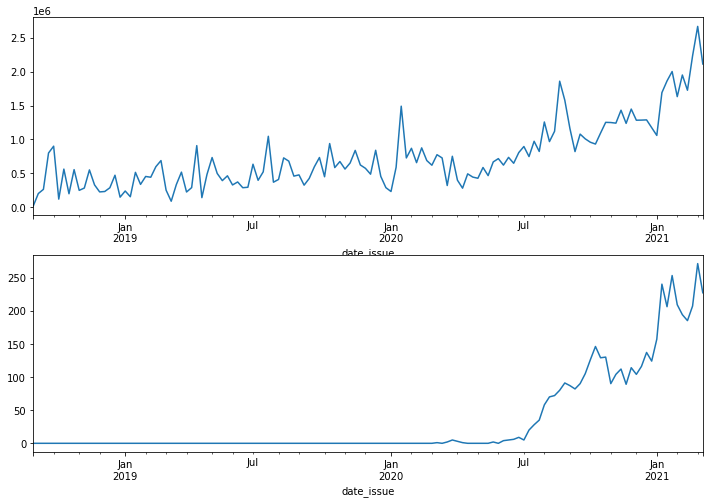

In [9]:
#Plotting weekly
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,8))
data_w['amount'].plot(ax=ax1)
data_w['covid_claims'].plot(ax=ax2)


<AxesSubplot:xlabel='date_issue'>

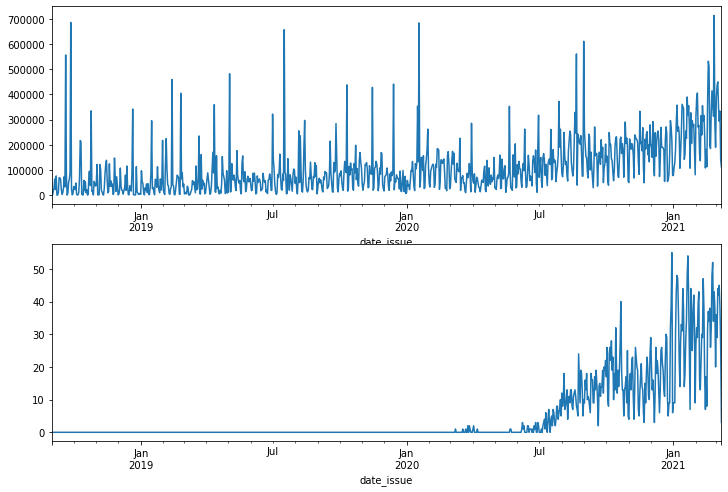

In [10]:
#Plotting daily
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,8))
data_d['amount'].plot(ax=ax1)
data_d['covid_claims'].plot(ax=ax2)

### Trying with weekly data

In [11]:
# Checking for stationarity
pvalue_a = adfuller(data_w['amount'])[1]

pvalue_c = adfuller(data_w['covid_claims'])[1]

def stationary(pvalue):
    if pvalue < 0.05:
        print('TS is stationary')
    else:
        print('TS is not stationary')
stationary(pvalue_a), pvalue_a, stationary(pvalue_c), pvalue_c

TS is not stationary
TS is not stationary


(None, 0.9820064277979804, None, 0.9987979289220925)

In [12]:
# Splitting Weekly data 

split = 0.8
split_index = round(len(data_w)*split)

train = data_w.iloc[:split_index]
test = data_w.iloc[split_index:]

train.head(1), train.tail(1), test.head(1), test.tail(1)

(            amount  covid_claims
 date_issue                      
 2018-09-03   16683             0,
              amount  covid_claims
 date_issue                       
 2020-09-07  1162316            87,
             amount  covid_claims
 date_issue                      
 2020-09-14  820467            82,
              amount  covid_claims
 date_issue                       
 2021-03-08  2111986           227)

In [13]:
# Separating variables
endog_train = train.drop(columns = 'covid_claims')
exog_train = train.drop(columns = 'amount')
endog_test = test.drop(columns = 'covid_claims')
exog_test = test.drop(columns = 'amount')

In [14]:
endog_test.head(1), exog_test.head(1), endog_test.tail(1), exog_test.tail(1)


(            amount
 date_issue        
 2020-09-14  820467,
             covid_claims
 date_issue              
 2020-09-14            82,
              amount
 date_issue         
 2021-03-08  2111986,
             covid_claims
 date_issue              
 2021-03-08           227)

### Autoarima raw_data with exogenous variable

In [15]:
# Autoarima raw_data with exogenous variable

autoarima_raw = pm.auto_arima(y = endog_train, X= exog_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=52,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=1501.809, Time=1.15 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1674.394, Time=0.21 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=2.56 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1489.745, Time=1.13 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1499.991, Time=0.28 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1486.019, Time=2.13 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1484.020, Time=1.94 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=1486.019, Time=3.74 sec
 ARIMA(0,1,1)(2,1,1)[52]             : AIC=1488.019, Time=4.50 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=1.80 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=1485.602, Time=3.63 sec
 ARIMA(0,1,2)(1,1,0)[52]             : AIC=1483.202, Time=4.63 sec
 ARIMA(0,1,2)(0,1,0)[52]             : AIC=1496.847, Time=0.51 sec
 ARIMA(0,1,2)(2,1,0)[52]             : AIC=1485.189, Time=21.65 sec
 ARIMA(0,1,2)(1,1,1)[52]    

In [16]:
autoarima_raw.order


(2, 1, 1)

In [17]:
autoarima_raw.summary()
# Split = 0.8
#m=7, BM= ARIMA(0,1,1)(0,1,2)[7], AIC=2734 
#m=1, BM= ARIMA(0,1,1)(0,0,0)[0], AIC=2896 
#m=52, BM= ARIMA(2,1,1)(1,1,0)[52], AIC=1479

# Split = 0.7
# Different best model:  ARIMA(0,1,1)(1,1,0)[52] AIC= 1092.470 however MAE is way worse than with Split = 0.8


#Split= 0.5
# Best model:  ARIMA(0,1,0)(1,1,0)[52]  AIC = 354.192

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  106
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 52)   Log Likelihood                -733.934
Date:                             Thu, 11 Mar 2021   AIC                           1479.867
Time:                                     16:32:20   BIC                           1491.689
Sample:                                 09-03-2018   HQIC                          1484.413
                                      - 09-07-2020                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
covid_claims  4147.3093   3776.390      1.098      0.272   -3254.278    1.15e+04
ar.L1            0.0756      0.454      0.167      0.868      -0.814       0.965
ar.L2           -0.1447      0.328     -0.442      0.659      -0.787       0.497
ma.L1           -0.7231      0.439     -1.645      0.100      -1.585       0.138
ar.S.L52        -0.8056      0.295     -2.734      0.006      -1.383      -0.228
sigma2        8.756e+10      0.000   2.47e+14      0.000    8.76e+10    8.76e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                31.21
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                             1.14
Prob(H) (two-sided):                  0.26   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.97e+29. Standard errors may be unstable.
"""

In [18]:
# Build model
best_sarima = SARIMAX(endog= endog_train, exog= exog_train, order=(2, 1, 1),seasonal_order=(1, 1, 0, 52))
best_sarima = best_sarima.fit()


/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


In [19]:
prediction = best_sarima.get_prediction(start = '2020-09-14', end = '2021-03-08', dynamic = True, full_results = True, exog = exog_test)

In [20]:
prediction.row_labels

DatetimeIndex(['2020-09-14', '2020-09-21', '2020-09-28', '2020-10-05',
               '2020-10-12', '2020-10-19', '2020-10-26', '2020-11-02',
               '2020-11-09', '2020-11-16', '2020-11-23', '2020-11-30',
               '2020-12-07', '2020-12-14', '2020-12-21', '2020-12-28',
               '2021-01-04', '2021-01-11', '2021-01-18', '2021-01-25',
               '2021-02-01', '2021-02-08', '2021-02-15', '2021-02-22',
               '2021-03-01', '2021-03-08'],
              dtype='datetime64[ns]', freq='W-MON')

In [21]:
predicted_amount = prediction.prediction_results.forecasts[0]

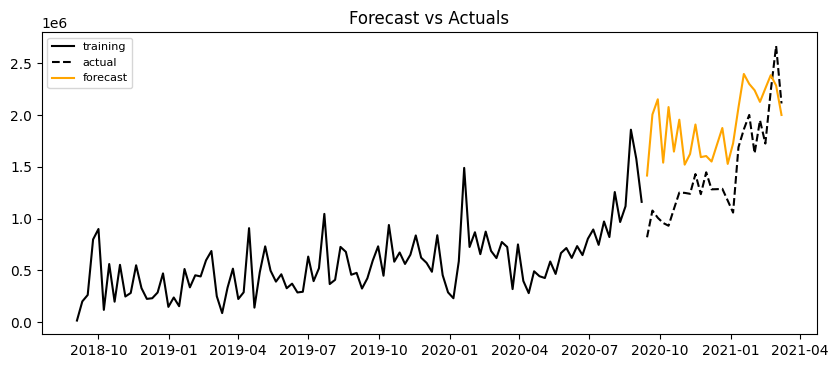

In [22]:
plot_forecast(predicted_amount, endog_train, endog_test)

In [23]:
# computing mae
best_sarima_performance = pd.DataFrame(endog_test)
best_sarima_performance['predicted_amount'] = predicted_amount
best_sarima_performance.rename(columns={0: 'amount'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['amount'] - best_sarima_performance['predicted_amount'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()

491869.3285936978

In [24]:
best_sarima_performance

,amount,predicted_amount,absolute_error
date_issue,,,
2020-09-14,820467,1.416365e+06,5.958978e+05
2020-09-21,1078408,2.005331e+06,9.269232e+05
2020-09-28,1008514,2.152398e+06,1.143884e+06
2020-10-05,958498,1.540710e+06,5.822122e+05
2020-10-12,931685,2.077438e+06,1.145753e+06
2020-10-19,1094071,1.647569e+06,5.534982e+05
2020-10-26,1251763,1.955409e+06,7.036459e+05
2020-11-02,1249102,1.521520e+06,2.724180e+05
2020-11-09,1240029,1.624359e+06,3.843300e+05


In [26]:
mean_absolute_percentage_error(best_sarima_performance['amount'], best_sarima_performance['predicted_amount'])

0.40448744709989154

In [27]:

# Split = 0.8
# Model = SARIMAX(endog= endog_train, exog= exog_train, order=(2, 1, 1),seasonal_order=(1, 1, 0, 52)) 
# MAE= 491869.3285936978

# Split = 0.7
# Model = SARIMAX(endog= endog_train, exog= exog_train, order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))
# MAE= 9481910.547212224

# Split = 0.9
# Model = SARIMAX(endog= endog_train, exog= exog_train, order=(2, 1, 1),seasonal_order=(1, 1, 0, 52)) 
# MAE= 613663.193140553 

# Changing split does not improve performance


### Trying with daily data

In [28]:
# Splitting Daily data 

split = 0.8
split_index = round(len(data_d)*split)

train_d = data_d.iloc[:split_index]
test_d = data_d.iloc[split_index:]

train_d.head(1), train_d.tail(1), test_d.head(1), test_d.tail(1)

(            amount  covid_claims
 date_issue                      
 2018-09-01     168             0,
             amount  covid_claims
 date_issue                      
 2020-09-05   93183            10,
             amount  covid_claims
 date_issue                      
 2020-09-06   67910            11,
             amount  covid_claims
 date_issue                      
 2021-03-08  111107             3)

In [29]:
# Separating variables
endog_train_d = train_d.drop(columns = 'covid_claims')
exog_train_d = train_d.drop(columns = 'amount')
endog_test_d = test_d.drop(columns = 'covid_claims')
exog_test_d = test_d.drop(columns = 'amount')

In [30]:
endog_test_d.head(1), exog_test_d.head(1), endog_test_d.tail(1), exog_test_d.tail(1)


(            amount
 date_issue        
 2020-09-06   67910,
             covid_claims
 date_issue              
 2020-09-06            11,
             amount
 date_issue        
 2021-03-08  111107,
             covid_claims
 date_issue              
 2021-03-08             3)

### Autoarima raw_data with exogenous variable

In [31]:
# Autoarima raw_data with exogenous variable

autoarima_raw = pm.auto_arima(y = endog_train_d, X= exog_train_d, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=23465.709, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=19016.664, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=18677.311, Time=0.46 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=18679.285, Time=0.79 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=18679.282, Time=1.40 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=18680.943, Time=1.96 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=18678.280, Time=0.92 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=18662.011, Time=0.81 sec
 ARIMA(0,1,2)(0,1,0)[7]             : AIC=inf, Time=0.72 sec
 ARIMA(0,1,2)(1,1,1)[7]             : AIC=18663.991, Time=1.44 sec
 ARIMA(0,1,2)(0,1,2)[7]             : AIC=18663.989, Time=2.64 sec
 ARIMA(0,1,2)(1,1,0)[7]             : AIC=i

In [33]:
#m=1 AIC=18000
# Build model ARIMA(2,1,2)(0,1,1)[7]  
best_sarima_d = SARIMAX(endog= endog_train_d, exog= exog_train_d, order=(2, 1, 2),seasonal_order=(0, 1, 1, 7))
best_sarima_d = best_sarima_d.fit()

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsm

In [37]:
prediction = best_sarima_d.get_prediction(start = '2020-09-06', end = '2021-03-08', dynamic = True, full_results = True, exog = exog_test_d)

In [38]:
predicted_amount = prediction.prediction_results.forecasts[0]

In [39]:
prediction.row_labels

DatetimeIndex(['2020-09-06', '2020-09-07', '2020-09-08', '2020-09-09',
               '2020-09-10', '2020-09-11', '2020-09-12', '2020-09-13',
               '2020-09-14', '2020-09-15',
               ...
               '2021-02-27', '2021-02-28', '2021-03-01', '2021-03-02',
               '2021-03-03', '2021-03-04', '2021-03-05', '2021-03-06',
               '2021-03-07', '2021-03-08'],
              dtype='datetime64[ns]', length=184, freq='D')

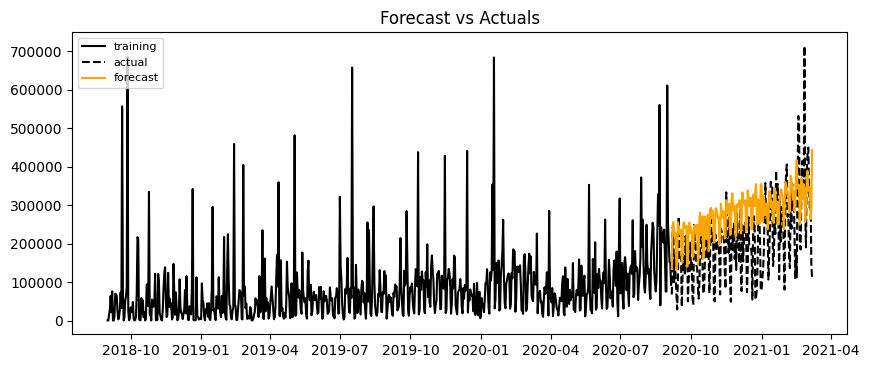

In [41]:
plot_forecast(predicted_amount, endog_train_d, endog_test_d)

In [43]:
# computing mae
best_sarima_performance = pd.DataFrame(endog_test_d)
best_sarima_performance['predicted_amount'] = predicted_amount
best_sarima_performance.rename(columns={0: 'amount'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['amount'] - best_sarima_performance['predicted_amount'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()

90370.68310887233

In [44]:
best_sarima_performance

,amount,predicted_amount,absolute_error
date_issue,,,
2020-09-06,67910,134250.723565,66340.723565
2020-09-07,242299,245570.225558,3271.225558
2020-09-08,230702,256416.667210,25714.667210
2020-09-09,99700,237902.659613,138202.659613
2020-09-10,170493,218764.095446,48271.095446
...,...,...,...
2021-03-04,350720,345879.637952,4840.362048
2021-03-05,293427,344787.182843,51360.182843
2021-03-06,333658,263581.500572,70076.499428


In [45]:
mean_absolute_percentage_error(best_sarima_performance['amount'], best_sarima_performance['predicted_amount'])

0.7535514050320014